# MLP from scratch

In this homework, you will code a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) with one hidden layer to classify text data.

Advice:
- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check about `torch.clamp`, `torch.nn.Parameter`

## 1. Some utilities and dataset for Part 2

In [16]:
import plygdata as pg
import numpy as np
data_array = np.array(pg.generate_data(pg.DatasetType.ClassifySpiralData, 0.0))
X = data_array[:,:-1]
Y = data_array[:,-1]
Y = (Y + 1)/2


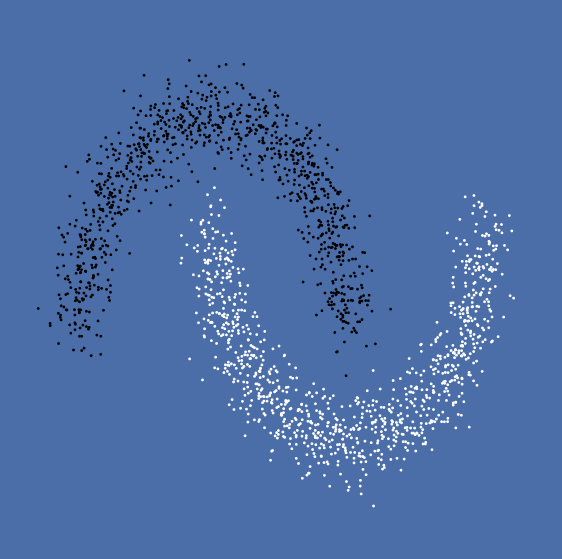

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plot the dataset
def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

from sklearn.datasets import make_moons, make_circles, make_classification
X, Y = make_moons(n_samples=2000, noise=0.1)
#X, Y = make_circles(n_samples=2000, noise=0.0)
#X, Y = make_classification(n_samples=4000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0)
%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
#x_min, x_max = -10, 10
#y_min, y_max = -10, 10
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9', figsize=(7, 7))
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

In [18]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
    #X = X.reshape((-1, 2, 1))
    Z = classifier.forward(to_forward.T)
    Z = Z.reshape(xx.shape)
    
    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X,Y)

## 2. MLP in numpy

Here you need to code your implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).

In [19]:
class MyReLU(object):
    def forward(self, x):
        self.out = np.maximum(x, 0)
        return self.out
        
    def backward(self, grad_output):
        return np.where(self.out > 0, grad_output, 0)
    
    def step(self, learning_rate):
        pass

class MySigmoid(object):
    def forward(self, x):
        self.out = np.reciprocal(1 + np.exp(-x))
        return self.out
    
    def backward(self, grad_output):
        return grad_output * self.out * (1 - self.out)
    
    def step(self, learning_rate):
        pass

Probably a good time to test your functions...

In [20]:
test_relu = MyReLU()
test_relu.forward([0, -1, 0.5, -0.5, 0.8, 1])

array([0. , 0. , 0.5, 0. , 0.8, 1. ])

In [21]:
test_relu.backward(np.ones(1))

array([0., 0., 1., 0., 1., 1.])

In [22]:
test_sig = MySigmoid()

test_sig.forward(np.ones(1))

array([0.73105858])

In [23]:
test_sig.backward(np.ones(1))

array([0.19661193])

A bit more complicated, you need now to implement your linear layer i.e. multiplication by a matrix W and summing with a bias b.

$$ y_i = \sum_j W_{i,j} x_j + b_i  \\
         d y_i / d W_{i, j} = x_j \\
         d loss / d y_i = grad_output[i] \\
         so \ d loss / d W_{i,j} = x_j *  gradoutput[i]  (by the chain rule) \\
          d loss / d x_j = \sum_i (d loss / d y_i) (d y_i / d x_j) $$

In [24]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        self.weights = np.random.randn(n_output, n_input)
        self.bias = np.random.randn(n_output, 1)

    def forward(self, x):
        self.input = x
        return self.weights @ x + self.bias
    
    def backward(self, grad_output):
        self.grad_weights = grad_output @ self.input.T
        self.grad_bias = np.sum(grad_output, axis=1, keepdims=True)

        grad_input = self.weights.T @ grad_output
        return grad_input
    
    def step(self, learning_rate):
        self.weights -= learning_rate * self.grad_weights
        self.bias -= learning_rate * self.grad_bias

Code your network. Note that with a Sigmoid layer, you should use the Binary Cross Entropy (BCE) loss.

In [25]:
class Sequential(object):
    def __init__(self):
        self.layers = [
            MyLinear(2, 10),
            MyReLU(),
            MyLinear(10, 10),
            MyReLU(),
            MyLinear(10, 10),
            MyReLU(),
            MyLinear(10, 10),
            MyReLU(),
            MyLinear(10, 1),
            MySigmoid()
        ]
        
    def forward(self, x):
        cur_out = x
        for layer in self.layers:
            cur_out = layer.forward(cur_out)
        return cur_out
        
    def compute_loss(self, out, label):
        if out == 0:
            out = 1e-10
        elif out == 1:
            out = out - 1e-10
        loss = -(label * np.log(out) + (1-label) * np.log(1-out))
        self.grad_output = (out - label)/(out*(1 - out))
        return loss

    def backward(self):
        cur_grad = self.grad_output
        for layer in reversed(self.layers):
            cur_grad = layer.backward(cur_grad)
    
    def step(self, learning_rate):
        for layer in self.layers:
            layer.step(learning_rate)

In [26]:
model = Sequential()

In [27]:
losses = []
learning_rate = 1e-2
epochs = 10
for epoch in range(epochs):
    loss_sum = 0 
    for it in range(len(X)):
        idx = np.random.randint(0, len(X))
        x = X[idx]
        x = x.reshape(2, 1)
        label = Y[idx]
        out = model.forward(x)
        loss_sum += model.compute_loss(out, label)
        model.backward()
        model.step(learning_rate)
    losses.append(loss_sum)


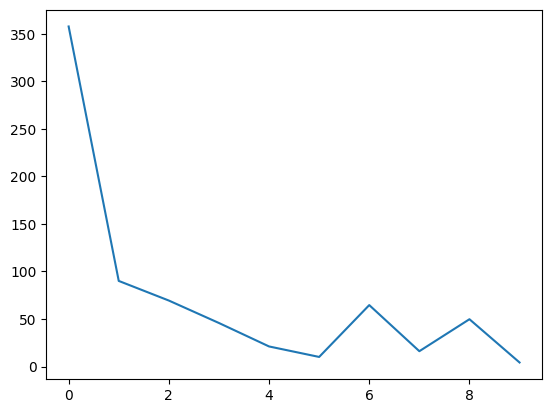

In [28]:
losses = np.array(losses)
losses = losses.reshape((-1, 1))
%matplotlib inline
plt.plot(losses)
plt.show()

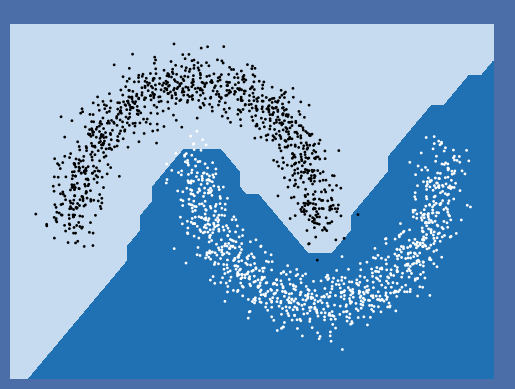

In [29]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, model)
fig.canvas.draw()

## 3. Using a Pytorch module

In this last part, use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

## 3.1. Load & Preprocess the IMDB Dataset

In this section, you are required to read and load the provided `csv` file, and perform the preprocessing steps as specified in the assignment's description.

In [30]:
import pandas as pd
import numpy as np

data = pd.read_csv("assets/data/imdb_dataset.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'assets/data/imdb_dataset.csv'

In [ ]:
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data["sentiment"] = le.fit_transform(data["sentiment"])

In [ ]:
data["sentiment"]

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int32

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['sentiment'], test_size=0.2)

In [ ]:
positive_train_reviews = np.array(X_train[y_train == 1])
negative_train_reviews = np.array(X_train[y_train == 0])
print("positive review:")
print(positive_train_reviews[np.random.randint(0, len(positive_train_reviews))])
print("negative review:")
print(negative_train_reviews[np.random.randint(0, len(negative_train_reviews))])

positive review:
I wonder how someone could diss on this movie. It is based on an actual story. It is not necessarily about "Rugby" itself so to the one that posted on here that they need to make a "real" rugby movie, you missed the point. This is not another typical sports movie where a team sucks, they hire Emilio Estevez and turn the team around and win the championship and give everyone the warm and fuzzies. It focuses on a STORY. It shows how someone can change his or her life for the better. The movies now days are all about sex, drugs, partying etc. That is Hollywood. I am a big fan of movies, but I have to say this was an inspirational movie with a great message. If you consider yourself a "tough guy" don't watch the movie, it won't live up to your standards. If you want to watch a good, inspirational movie, this is a good one.
negative review:
What's the point of reviewing a movie like this? It's painfully and embarrassingly bad, not even in a way that allows you to make fun o

In [ ]:
positive_train_reviews = np.array(X_test[y_test == 1])
negative_train_reviews = np.array(X_test[y_test == 0])
print("positive review:")
print(positive_train_reviews[np.random.randint(0, len(positive_train_reviews))])
print("negative review:")
print(negative_train_reviews[np.random.randint(0, len(negative_train_reviews))])

positive review:
This is just my all time favorite movie. Nothing special. It's just so incredibly detailed. Makes me cry just thinking about it. Geronimo Bill is the nicest guy I can imagine. Money is not important. Bamboo spears are important. You don't need money to get what you need. If you need something it will just come to you. If people would realize that the world would be a much better place. Whatever you do, don't do it for the money.
negative review:
I knew this would be one of the worst movies I could have imagined...but in just 20 short minutes it actually exceeded my low expections by being possibly THE worst movie I have ever seen.<br /><br />I have already wasted too much time typing about it...trust me, it sucks.


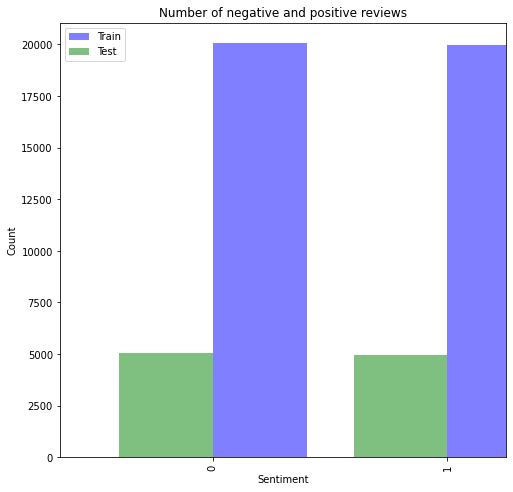

In [ ]:
import matplotlib.pyplot as plt
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()
fig, ax = plt.subplots()
train_counts.plot.bar(ax=ax, color='blue', alpha=0.5, width=0.4, position=0, label='Train', figsize=(8, 8))
test_counts.plot.bar(ax=ax, color='green', alpha=0.5, width=0.4, position=1, label='Test')
ax.set_title('Number of negative and positive reviews')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
ax.legend()
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords

# Download stopwords list
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english')) 

# Interface lemma tokenizer from nltk with sklearn
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

# Lemmatize the stop words
tokenizer=LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))

# Create TF-idf model
vectorizer = TfidfVectorizer(max_features=3000,stop_words=token_stop, 
                              tokenizer=tokenizer)
vectorizer.fit(X_train.values)
X_train_vec = vectorizer.transform(X_train.values)
X_test_vec = vectorizer.transform(X_test.values)
#features = vectorizer.fit_transform(data["review"])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ALI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ALI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\ALI\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
(X_train_vec.min() >= 0 and X_train_vec.max() <= 1) and (X_test_vec.min() >= 0 and X_test_vec.max() <= 1)

True

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers, optimizers

model = models.Sequential()
NEURONS = 128
model.add(layers.Dense(NEURONS, activation='relu', input_shape=(3000,)))
model.add(layers.Dense(NEURONS, activation='relu'))
model.add(layers.Dense(NEURONS, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.SGD(lr=0.1)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(X_train_vec.toarray(), y_train_np,
                    epochs=20,
                    batch_size=128,
                    validation_data=(X_test_vec.toarray(), y_test_np))

Epoch 1/20
313/313 [==============================] - 2s 6ms/step - loss: 0.6903 - accuracy: 0.5610 - val_loss: 0.6834 - val_accuracy: 0.5880
Epoch 2/20
313/313 [==============================] - 2s 5ms/step - loss: 0.6242 - accuracy: 0.7210 - val_loss: 0.5509 - val_accuracy: 0.6768
Epoch 3/20
313/313 [==============================] - 2s 5ms/step - loss: 0.4801 - accuracy: 0.7621 - val_loss: 0.3647 - val_accuracy: 0.8418
Epoch 4/20
313/313 [==============================] - 2s 5ms/step - loss: 0.3867 - accuracy: 0.8273 - val_loss: 0.4255 - val_accuracy: 0.7986
Epoch 5/20
313/313 [==============================] - 2s 6ms/step - loss: 0.3484 - accuracy: 0.8471 - val_loss: 0.4782 - val_accuracy: 0.7749
Epoch 6/20
313/313 [==============================] - 2s 5ms/step - loss: 0.3272 - accuracy: 0.8583 - val_loss: 0.3308 - val_accuracy: 0.8577
Epoch 7/20
313/313 [==============================] - 2s 5ms/step - loss: 0.3005 - accuracy: 0.8729 - val_loss: 0.3386 - val_accuracy: 0.8547
Epoch 

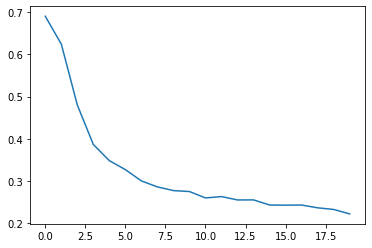

In [ ]:
plt.plot(history.history["loss"])

## 3.2. MLP in torch

In [ ]:
import torch
import torch.nn as nn
import math

class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MyLinear_mod, self).__init__()
        self.weights = nn.Parameter(torch.empty((n_output, n_input)))
        self.bias = nn.Parameter(torch.empty(n_output))
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))
        #nn.init.normal_(self.weights)
        bound = 1 / math.sqrt(n_input)
        nn.init.uniform_(self.bias, -bound, bound)
        #nn.init.normal_(self.bias)



    def forward(self, x):
        return x.matmul(self.weights.t()) + self.bias
        #return torch.nn.functional.linear(x, self.weights, self.bias)
        
class MyReLU_mod(nn.Module):
    def __init__(self):
        super(MyReLU_mod, self).__init__()
        
    def forward(self, x):
        return torch.max(x, torch.tensor(0.))

Define your network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [ ]:
X_train_vec.shape

(40000, 3000)

In [ ]:
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

In [ ]:
X_train_tensor = torch.tensor(X_train_vec.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_vec.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).view(-1, 1)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
NEURONS = 128
# model = nn.Sequential(
#     MyLinear_mod(3000,NEURONS),
#     MyReLU_mod(),
#     MyLinear_mod(NEURONS, NEURONS),
#     MyReLU_mod(),
#     MyLinear_mod(NEURONS, NEURONS),
#     MyReLU_mod(),
#     MyLinear_mod(NEURONS, 1),
#     nn.Sigmoid()
# )
# model = nn.Sequential(
#     MyLinear_mod(3000,NEURONS),
#     nn.ReLU(),
#     MyLinear_mod(NEURONS, NEURONS),
#     nn.ReLU(),
#     MyLinear_mod(NEURONS, NEURONS),
#     nn.ReLU(),
#     MyLinear_mod(NEURONS, 1),
#     nn.Sigmoid()
# )

model = nn.Sequential(
    nn.Linear(3000,NEURONS),
    nn.ReLU(),
    nn.Linear(NEURONS, NEURONS),
    nn.ReLU(),
    nn.Linear(NEURONS, NEURONS),
    nn.ReLU(),
    nn.Linear(NEURONS, 1),
    nn.Sigmoid()
)

In [ ]:
from torch import optim
from tqdm import tqdm


optimizer = optim.SGD(model.parameters(), lr=0.1)
#optimizer = optim.RMSprop(model.parameters(), lr=0.001)

losses = []
criterion = nn.BCELoss()
epochs = 20
for epoch in range(epochs):
    model.train()
    
    train_num_correct = 0
    train_num_samples = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    loss_sum = 0
    for batch_idx, (features, labels) in enumerate(pbar):
        optimizer.zero_grad()

        out = model(features)
        loss = criterion(out, labels)
        #print(labels.shape)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        binary_preds = (out > 0.5).float()
        train_num_correct += (binary_preds.int() == labels.int()).sum().item()
        train_num_samples += labels.size(0)
        accuracy = train_num_correct / train_num_samples
        pbar.set_postfix({'Loss': loss.item(), 'Accuracy': f'{accuracy:.2f}%'})
    losses.append(loss_sum / train_num_samples)

    #print(f"train: {train_num_correct / train_num_samples}")
    model.eval()
    
    test_num_correct = 0
    test_num_samples = 0

    # evaluate model on test dataset
    with torch.no_grad():
        for inputs, targets in test_loader:
            # compute outputs
            outputs = model(inputs)
            
            # calculate test accuracy
            binary_preds = (outputs > 0.5).float()
            #print(targets.shape)
            targets = targets.reshape((-1, 1))
            test_num_correct += (binary_preds == targets).sum().item()
            test_num_samples += targets.size(0)
        print(f"test: {test_num_correct / test_num_samples}")
        

Epoch 1: 100%|██████████| 313/313 [00:02<00:00, 135.70it/s, Loss=0.692, Accuracy=0.51%]


test: 0.505


Epoch 2: 100%|██████████| 313/313 [00:02<00:00, 144.30it/s, Loss=0.681, Accuracy=0.54%]


test: 0.5059


Epoch 3:  59%|█████▉    | 185/313 [00:01<00:01, 94.08it/s, Loss=0.581, Accuracy=0.66%] 


RuntimeError: all elements of input should be between 0 and 1

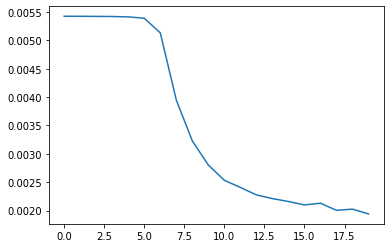

In [ ]:
plt.plot(losses)